## Predicting Hotel Review Topics

Employing Ml techiques to cluster hotel reviews into topics.  Dataset is from kaggle:
- https://www.kaggle.com/datafiniti/hotel-reviews.

It contains over 35,000 distinct reviews of 1,000 different hotels around the world. Attempt to isolate the text of the
reviews and identify topics (what people are talking about). Then create a machine
learning model that can predict/identify the topics of incoming reviews


In [53]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from time import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
import pandas as pd
from nltk.tokenize import sent_tokenize
from sklearn.decomposition import PCA 
from sklearn.decomposition import TruncatedSVD
from functools import reduce
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [54]:
hotel_reviews =  pd.read_csv('data\\7282_1.csv')

In [55]:
hotel_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35912 entries, 0 to 35911
Data columns (total 19 columns):
address                 35912 non-null object
categories              35912 non-null object
city                    35912 non-null object
country                 35912 non-null object
latitude                35826 non-null float64
longitude               35826 non-null float64
name                    35912 non-null object
postalCode              35857 non-null object
province                35912 non-null object
reviews.date            35653 non-null object
reviews.dateAdded       35912 non-null object
reviews.doRecommend     0 non-null float64
reviews.id              0 non-null float64
reviews.rating          35050 non-null float64
reviews.text            35890 non-null object
reviews.title           34290 non-null object
reviews.userCity        16263 non-null object
reviews.username        35869 non-null object
reviews.userProvince    17518 non-null object
dtypes: float64(5), 

In [56]:
hotel_reviews.shape

(35912, 19)

In [57]:
hotel_reviews.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


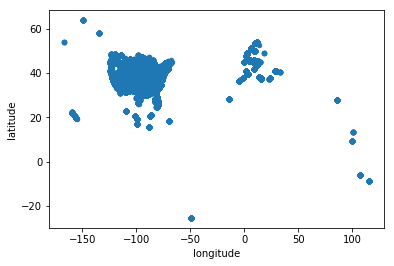

In [58]:
hotel_reviews.plot.scatter(x='longitude', y='latitude');

In [59]:
hotel_reviews.country.value_counts()

US    35912
Name: country, dtype: int64

Only reviews from USA, lets try including only mainland USA and generate a map

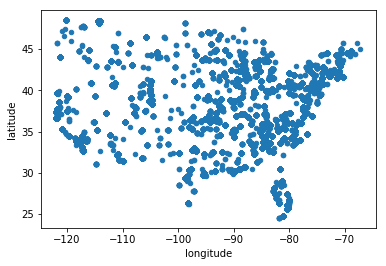

In [60]:
hotel_reviews = hotel_reviews[((hotel_reviews['latitude']<=50.0) &
(hotel_reviews['latitude']>=24.0)) & ((hotel_reviews['longitude']<=-65.0) &
(hotel_reviews['longitude']>=-122.0))]
hotel_reviews.plot.scatter(x='longitude', y='latitude');

In [61]:
hotel_reviews.shape

(30692, 19)

In [62]:
#lets get the review data
texts = hotel_reviews['reviews.text']

In [63]:
print(texts[:1])

57    to share your opinion of this businesswith YP ...
Name: reviews.text, dtype: object


## The clustering model

Use the *sent_tokenize* function to take in a single string and output the sentence as an ordered list of sentences
separated by punctuation.  Apply to each review and create a single list called *sentences*

In [64]:
sentences = reduce(lambda x, y:x+y, texts.apply(lambda x:sent_tokenize(str(x).encode().decode('utf-8','ignore'))))


In [65]:
len(sentences)

118151

In [66]:
#create a document-term matrix using TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2),stop_words='english')
tfidf_transformed = tfidf.fit_transform(sentences)
tfidf_transformed

<118151x280901 sparse matrix of type '<class 'numpy.float64'>'
	with 1180273 stored elements in Compressed Sparse Row format>

## Latent semantic analysis (Latent semantic indexing)

In [67]:
#get 10 topics
svd = TruncatedSVD(n_components=10)
#give each doc a unit norm
normalizer = Normalizer()

lsa = Pipeline(steps=[('tfidf',tfidf),('svd',svd),('normalizer',normalizer)])
lsa_sentences = lsa.fit_transform(sentences)

In [68]:
#rows vs columns
lsa_sentences.shape

(118151, 10)

In [69]:
#apply kmeans clustering
cluster = KMeans(n_clusters=10)
cluster.fit(lsa_sentences)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Time our fit and predict for our original document-term matrix of shape (118151,280901)
and then for our latent semantic analysis of shape (118151, 10) to see the differences:

In [70]:
#takes too long!!!

#%%timeit
# time it takes to cluster on the original document-term matrix of shape (118151, 280901)
#cluster.fit(tfidf_transformed)

In [71]:
#%%timeit
# time the prediction phase of the Kmeans clustering
#cluster.predict(tfidf_transformed)


In [73]:
#try on LSA
#%%timeit
# time the time to cluster after latent semantic analysis of shape (118151, 10)
cluster.fit(lsa_sentences)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [74]:
cluster.predict(lsa_sentences)


array([0, 0, 0, ..., 2, 0, 0])

In [86]:
#transform the texts to a cluster distance space where each row represents an observation

print(cluster.transform(lsa_sentences).shape)

predicted_cluster = cluster.predict(lsa_sentences)
print(predicted_cluster)

(118151, 10)
[0 0 0 ... 2 0 0]


In [83]:
# Distribution of "topics"
pd.Series(predicted_cluster).value_counts(normalize=True)# create DataFrame of texts and predicted topics
texts_df = pd.DataFrame({'text':sentences,'topic':predicted_cluster})
texts_df.head()


,text,topic
0,to share your opinion of this businesswith YP ...,0
1,to share your opinion of this businesswith YP ...,0
2,to share your opinion of this businesswith YP ...,0
3,"We had a wonderful, relaxing time.",3
4,The staff were completely attentive and accomm...,4


In [84]:
print( "Top terms per cluster:")
original_space_centroids = svd.inverse_transform(cluster.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = lsa.steps[0][1].get_feature_names()
for i in range(10):
    print ("Cluster %d:" % i)
    print(', '.join([terms[ind] for ind in order_centroids[i, :5]]))
    print()
lsa.steps[0][1]


Top terms per cluster:
Cluster 0:
room, room clean, hotel, good, nice

Cluster 1:
hotel, recommend, good, recommend hotel, hotel clean

Cluster 2:
clean, room clean, rooms, clean comfortable, hotel

Cluster 3:
hotel, room, good, great, stay

Cluster 4:
staff, friendly, staff friendly, helpful, friendly helpful

Cluster 5:
nice, room, hotel, staff, nice hotel

Cluster 6:
great, location, breakfast, hotel, stay

Cluster 7:
good, breakfast, breakfast good, room, great

Cluster 8:
stay, hotel, good, enjoyed stay, enjoyed

Cluster 9:
comfortable, bed, clean comfortable, bed comfortable, room



TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [85]:
#try predict the cluster of a new review, like so:
# topic prediction
print(cluster.predict(lsa.transform(['I definitely recommend this hotel'])))
print(cluster.predict(lsa.transform(['super friendly staff. Love it!'])))


[1]
[4]


Predictions look pretty accurate